In [1]:
import cv2
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import rospy

import pyrealsense2
from realsense_depth import *
import numpy as np
from matplotlib import pyplot as plt

import open3d as o3d
from open3d_ros_helper import open3d_ros_helper as orh
from scipy import spatial

image = None

rospy.init_node("my_pic", anonymous=True)
bridge = CvBridge()
loop_rate = rospy.Rate(0.5) # Node cycle rate (in Hz).
#np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def grab_frame():
    
    frame_color=rospy.wait_for_message('/camera/color/image_raw', Image, timeout=None) #wait_for_message(topic, topic_type, timeout=None): 
    cv_image_color = bridge.imgmsg_to_cv2(frame_color, desired_encoding='rgb8')
    
    frame_depth = rospy.wait_for_message('/camera/depth/image_raw', Image, timeout=None) #wait_for_message(topic, topic_type, timeout=None): 
    cv_image_depth = bridge.imgmsg_to_cv2(frame_depth)
    
    return cv_image_color, cv_image_depth

In [3]:
def visualize_rgbd(rgbd_image):
    print(rgbd_image)
    #o3d.visualization.draw_geometries([rgbd_image])
    
    #intrinsic = o3d.camera.PinholeCameraIntrinsic()
    #intrinsic.intrinsic_matrix =  [[462.1379699707031, 0.0, 320.0], [0.0, 462.1379699707031, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[347.99755859375, 0.0, 320.0], [0.0, 347.99755859375, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[602.71783447, 0.0, 313.06835938], [0.0, 601.61364746, 230.37461853], [0.0, 0.0, 1.0]]
    
    #w = 640
    #h = 480
    #fx = 602.71783447
    #fy = 601.61364746
    #cx = 313.06835938
    #cy = 230.37461853
    
    #Color frame ROS camera
    #w = 640
    #h = 480
    #fx = 462.1379699707031
    #fy = 462.1379699707031
    #cx = 320.0
    #cy = 240.0
    
    #Depth frame ROS camera
    w = 640
    h = 480
    fx = 347.99755859375
    fy = 347.99755859375
    cx = 320.0
    cy = 240.0    
    
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx,fy, cx, cy)
    intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
    
    cam = o3d.camera.PinholeCameraParameters()
    cam.intrinsic = intrinsic
    
    #cam.extrinsic = np.array([[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 1.]])
    #pcd = o3d.geometry.create_point_cloud_from_rgbd_image(rgbd_image, cam.intrinsic, cam.extrinsic)
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam.intrinsic)
    #pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,intrinsic)
    
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down.
    
    #o3d.visualization.draw_geometries([pcd])
    
    return pcd
    
    
def tst_dataset(color_frame,depth_frame):
    color_raw = o3d.geometry.Image(np.asarray(color_frame))
    depth_raw = o3d.geometry.Image(np.asarray(depth_frame.astype(np.uint16)) )
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)
    pcd = visualize_rgbd(rgbd_image)
    return pcd


def box_pos(x_coord, y_coord, width, height, centered=0):
    if centered == 0:
        start_point = (x_coord, y_coord) # represents the top left corner of rectangle
        end_point = (x_coord+width-1, y_coord+height-1)  # represents the bottom right corner of rectangle
    elif centered == 1:
        new_x = x_coord - (np.floor(width/2)-1).astype(int)
        new_y = y_coord - (np.floor(height/2)-1).astype(int)
        start_point = (new_x, new_y) 
        end_point = (new_x+width, new_y+height)
    return start_point, end_point



In [4]:
color_frame, depth_frame = grab_frame()
print("color frame:",color_frame.shape, " Depth frame:",depth_frame.shape)

#Check center pixel distance

point = (320, 240)

#color_frame, depth_frame = grab_frame()

distance = depth_frame[point[1], point[0]]
print("Center of image:", distance, "mm")

color frame: (480, 640, 3)  Depth frame: (480, 640)
Center of image: 288 mm



start_point,end_point = box_pos(320, 240, 10, 10, centered=1)  #x,y,width,height, 0-- top left coord, 1--- center coord

cf = color_frame
for i in range (color_frame.shape[0]):
    for j in range (color_frame.shape[1]):
        if depth_frame[i][j] == 0:
            cf[i][j] = [0 , 0, 0] 

plt.imshow(cf)
plt.show()
window_name = 'Filtered_image'  # Window name in which image is displayed

cv2.rectangle(cf, start_point, end_point, (0, 0, 255), 1)
cv2.imshow(window_name, cf)
cv2.waitKey(0)
cv2.destroyAllWindows()


#color_frame_crop = cf[start_point[1]:end_point[1], start_point[0]:end_point[0]]

color_frame_crop = cf[start_point[1]:end_point[1], start_point[0]:end_point[0]]
depth_frame_crop = depth_frame[start_point[1]:end_point[1], start_point[0]:end_point[0]]

print(depth_frame_crop.shape)
zz=depth_frame_crop.T
print(zz.shape)

#cv2.imshow("cropped", depth_frame_crop)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [5]:
pt_cloud = tst_dataset(color_frame, depth_frame)


RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


In [6]:
downpcd = pt_cloud.voxel_down_sample(voxel_size=0.01)
#o3d.visualization.draw_geometries([downpcd])

print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30)) #radius in meters

#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

v1_normal = np.array(downpcd.normals)
v1_normal_pts = np.array(downpcd.points)


Recompute the normal of the downsampled point cloud


In [7]:
print("Align normals towards camera") #orient_normals_towards_camera_location(self, camera_location=array([0.0, 0.0, 0.0]))

downpcd.orient_normals_towards_camera_location(camera_location=[0.0, 0.0, 1.0])

#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

v2_camera = np.array(downpcd.normals)
v2_camera_pts = np.array(downpcd.points)
v2_camera

Align normals towards camera


array([[ 5.15740827e-01,  8.52241230e-01,  8.77284714e-02],
       [ 3.48619300e-01,  9.30201692e-01,  1.14845093e-01],
       [-5.34517185e-01,  8.38628850e-01,  1.04847655e-01],
       ...,
       [-3.88838356e-04, -7.21259295e-01,  6.92665055e-01],
       [ 1.50665203e-04, -1.54979768e-02,  9.99879888e-01],
       [-2.47199066e-01, -1.07230445e-01,  9.63013112e-01]])

In [8]:
idx = np.where(abs(v1_normal_pts[:,2]) < (distance/1000)+0.01)[0] #fetch all indexes of values less than distance of center of img 0.3 in column 3 of rec
#idx = np.where(abs(v1_normal_pts[:,2]) < abs(v1_normal_pts[:,2]).max()-0.02)[0] #Remove ground

filtered_Pt_Cloud = downpcd.select_by_index(idx, invert=False)
o3d.visualization.draw_geometries([filtered_Pt_Cloud], point_show_normal=True)
nor = np.array(filtered_Pt_Cloud.normals)
pts = np.array(filtered_Pt_Cloud.points)
filtered_Pt_Cloud.get_center()


array([ 0.01071484,  0.0367714 , -0.24916008])

In [9]:
distance,index = spatial.KDTree(pts).query( filtered_Pt_Cloud.get_center() ) #find coordinates 
                                                                             #that are closest to the center 

print(distance)
print(index)
print()
print("Center Coordinates(ground truth):",filtered_Pt_Cloud.get_center())
print("Points Coordinates(estimated center point):",pts[index])
print("Normal Coordinates(Normal of estimated center point):",nor[index])
print("Tilt Angle:", np.round(np.degrees(angle_between((0,0,1), nor[index]))) ) 

0.004902498141305202
25

Center Coordinates(ground truth): [ 0.01071484  0.0367714  -0.24916008]
Points Coordinates(estimated center point): [ 0.00605751  0.03777038 -0.248     ]
Normal Coordinates(Normal of estimated center point): [ 0.0024496  -0.71852453  0.69549731]
Tilt Angle: 46.0


In [10]:
print('Angle: 0')
print()
print('Positive X count:', np.sum(np.array(nor[:,0]) >= 0, axis=0), 
      '  Positive Y count:',np.sum(np.array(nor[:,1]) >= 0, axis=0), 
      '  Positive Z count:',np.sum(np.array(nor[:,2]) >= 0, axis=0), '     Out of:',len(nor[:,0]))

Angle: 0

Positive X count: 616   Positive Y count: 0   Positive Z count: 741      Out of: 741


In [11]:
print("Estimated angle between Normal and Camera")
print()
arr = np.array([])
for i in range(len(nor)):
    arr = np.append(arr, [np.round(np.degrees(angle_between((0,0,1), nor[i])))])
    print(i+1," ", np.round(np.degrees(angle_between((0,0,1), nor[i]))) )

Estimated angle between Normal and Camera

1   46.0
2   46.0
3   46.0
4   46.0
5   46.0
6   46.0
7   46.0
8   46.0
9   46.0
10   46.0
11   46.0
12   46.0
13   46.0
14   46.0
15   46.0
16   46.0
17   46.0
18   46.0
19   46.0
20   46.0
21   46.0
22   46.0
23   46.0
24   46.0
25   46.0
26   46.0
27   46.0
28   46.0
29   47.0
30   46.0
31   46.0
32   46.0
33   46.0
34   47.0
35   46.0
36   46.0
37   46.0
38   46.0
39   46.0
40   46.0
41   46.0
42   46.0
43   46.0
44   46.0
45   46.0
46   46.0
47   46.0
48   46.0
49   46.0
50   46.0
51   46.0
52   46.0
53   46.0
54   46.0
55   46.0
56   46.0
57   46.0
58   46.0
59   46.0
60   46.0
61   46.0
62   46.0
63   46.0
64   46.0
65   46.0
66   46.0
67   46.0
68   46.0
69   46.0
70   46.0
71   46.0
72   46.0
73   46.0
74   46.0
75   46.0
76   46.0
77   46.0
78   46.0
79   46.0
80   46.0
81   46.0
82   46.0
83   46.0
84   46.0
85   46.0
86   46.0
87   46.0
88   46.0
89   46.0
90   46.0
91   46.0
92   46.0
93   46.0
94   46.0
95   46.0
96   46.0
97   4

In [12]:
arr.mean()

46.05398110661269

In [13]:
[0.303, 0.017, 0.456]

[0.303, 0.017, 0.456]

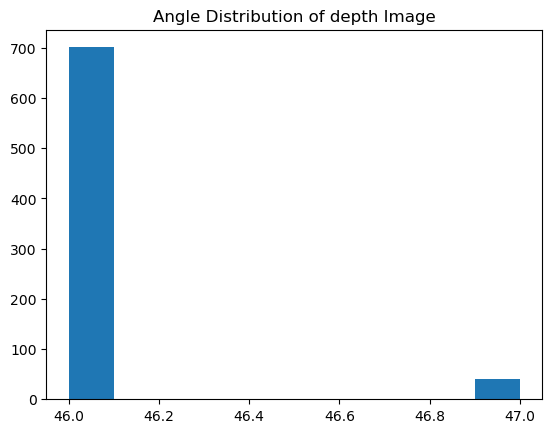

[[ 46. 701.]
 [ 47.  40.]]


In [14]:
hi=np.histogram(arr,bins=10)

plt.hist(arr,bins=10)
plt.title("Angle Distribution of depth Image")
plt.show()
unique, counts = np.unique(arr, return_counts=True)
print(np.asarray((unique, counts)).T)

In [15]:
unique, counts

(array([46., 47.]), array([701,  40]))

In [57]:
from scipy.spatial.transform import Rotation as R
import math

def getRotation(v1, v2):

    vec1 = v1 / np.linalg.norm(v1)
    vec2 = v2 / np.linalg.norm(v2)

    angle = math.acos(np.dot(vec1, vec2))
    vector = np.cross(vec1, vec2)/np.linalg.norm(np.cross(vec1, vec2))
    
    print("Angle:",angle)
    print("Vector:",vector)
    print()
    
    #Rotation = filtered_Pt_Cloud.get_rotation_matrix_from_axis_angle(angle*vector) #alternative Open3D lib.
    Rotation = R.from_rotvec(angle*vector)
    
    return Rotation, angle, vector


In [60]:
rot,angle, vector = getRotation([0,0,1], nor[index])

print("Axis-Angle:", angle*vector)
print()

print("Rotation Matrix:")
print(rot.as_matrix())
print()

r = rot.as_euler("YXZ", degrees=True)
r_quat = rot.as_quat()            #x,y,z,w format

print("Roll:", r[0], "Pitch:", r[1], "Yaw:", r[2])
print()
print("In Quaternion form xyzw:",r_quat)

Angle: 0.80168453702699
Vector: [ 0.99999419  0.00340919 -0.        ]

Axis-Angle: [ 0.80167988  0.0027331  -0.        ]

Rotation Matrix:
[[ 0.99999646  0.0010381   0.0024496 ]
 [ 0.0010381   0.69550085 -0.71852453]
 [-0.0024496   0.71852453  0.69549731]]

Roll: 0.20179983780435745 Pitch: 45.93279648411404 Yaw: 0.08551938476700577

In Quaternion form xyzw: [ 0.39019172  0.00133025 -0.          0.92073267]


In [27]:
#### ALTERNATIVE LIBRARY TO CONVERT AXIS ANGLE TO EULER OR QUATERNION, can do more than that
#Ref: http://docs.ros.org/en/kinetic/api/baldor/html/index.html

import baldor
za = baldor.axis_angle.to_euler(vector, angle, axes='sxyz')
print("Eular rotations by Baldor Library:",np.degrees(za))
za_quat = baldor.axis_angle.to_quaternion(vector, angle, isunit=False) #w,x,y,z format
print()
print("Quaternions by Baldor Library:",za_quat)

Eular rotations by Baldor Library: [45.93297408  0.14035196  0.05947904]

Quaternions by Baldor Library: [ 0.92073267  0.39019172  0.00133025 -0.        ]


In [62]:
##visualize Coordinate

import copy
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()

mesh_tx = copy.deepcopy(mesh).translate((0.5, 0, 0), relative=False)

mesh_ty = copy.deepcopy(mesh).translate((0, 1.3, 0))

print(f'Center of mesh: {mesh.get_center()}')
print(f'Center of mesh tx: {mesh_tx.get_center()}')
print(f'Center of mesh ty: {mesh_ty.get_center()}')

#o3d.visualization.draw_geometries([mesh, mesh_tx, mesh_ty])
o3d.visualization.draw_geometries([filtered_Pt_Cloud, mesh_tx])

Center of mesh: [0.05167549 0.05167549 0.05167549]
Center of mesh tx: [ 5.00000000e-01  7.66949702e-17 -2.99583991e-17]
Center of mesh ty: [0.05167549 1.35167549 0.05167549]
